In [143]:
import numpy as np 
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli

In [338]:
class VariationalDense():
    """Variational Dense Layer class
    Each layer has an associated dropout probability (or a keep probability (proba to keep the weight))
    Each of regularization terms have l squared divided by 2 times tau times number of sample and we warp up this and say it is lambda
    
    What we are doing here is approximate the matrix M where if you're dropping out the columns of the matrix and to obtain a new matrix W,
    then your set of w which you can regard as a sample from your variational approximating distribution, there still good for predictions
    
    We need bernouilli distribution for our dropout
    """
    def __init__(self,n_in, n_out,model_prob,model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs = self.model_prob, dtype = tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in,n_out], stddev = 0.01))#correspond to the matrix M that is being learned, this is what is going to be dropped out
        self.model_m = tf.Variable(tf.zeros([n_out]))#it is like the bias
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample(n_in,)),self.model_M
        )
        
    def __call__(self,X,activation = tf.identity):
        output = activation(tf.matmul(X,self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1 :
            output = tf.squeeze(output)
        return output
    
    @property
    def regularization(self):
        return self.model_lam * (self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
                     tf.reduce_sum(tf.square(self.model_m)))
    

## Creation of sample data

In [339]:
# we use ravel so insted of matrix (10,1) is is now a vector of size (10,)

n_samples = 100
X = np.random.normal(size = (n_samples,1))
y = np.random.normal(5. * np.cos(5. * X) / (np.abs(X)+1.),0.1).ravel()
X_pred = np.atleast_2d(np.linspace(-3,3,num = 100)).T #atleast_2d pour passer de taille (100,) à taille (100,1)
X = np.hstack((X,X**2,X**3))
X_pred = np.hstack((X_pred,X_pred**2,X_pred**3))

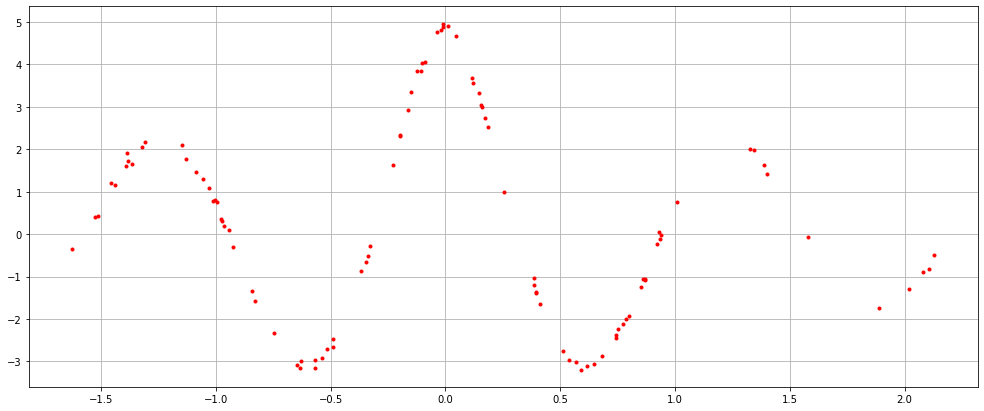

In [340]:
plt.figure( figsize = (17,7))
plt.plot(X[:,0],y,"r.")
plt.grid()
plt.show()

## Creation the Tensorflow model

In [341]:
n_feats = X.shape[1] #in this case 3
n_hidden = 100 # number hidden units
model_prob = 0.9
model_lam = 1e-2
model_X = tf.placeholder(tf.float32, [None,n_feats]) #shape is None by n_feats
model_y = tf.placeholder(tf.float32,[None])
model_l_1 = VariationalDense(n_feats,n_hidden,model_prob,model_lam)
model_l_2 = VariationalDense(n_hidden,n_hidden,model_prob,model_lam)
model_l_3 = VariationalDense(n_hidden,1,model_prob,model_lam)
model_out_1 = model_l_1(model_X,tf.nn.relu)
model_out_2 = model_l_2(model_out_1,tf.nn.relu)
model_pred = model_l_3(model_out_2)

model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
model_mse = model_sse / n_samples
model_loss = ( #negative log likelihood
    model_sse +
    model_l_1.regularization +
    model_l_2.regularization +
    model_l_3.regularization 
)

train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)


with tf.Session() as sess :
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        sess.run(train_step, {model_X : X, model_y : y})
        if i % 100 == 0 :
            mse = sess.run(model_mse, {model_X : X, model_y : y})
            print("Iteration {}. Mean squarred error : {:.4f}".format(i,mse))
    
    
    n_post = 1000
    Y_post = np.zeros((n_post,X_pred.shape[0]))
    for i in range(n_post):
        Y_post[i] = sess.run(model_pred, {model_X : X_pred})

Iteration 0. Mean squarred error : 5.5642
Iteration 100. Mean squarred error : 4.5021
Iteration 200. Mean squarred error : 1.8847
Iteration 300. Mean squarred error : 1.3111
Iteration 400. Mean squarred error : 1.0429
Iteration 500. Mean squarred error : 0.6851
Iteration 600. Mean squarred error : 0.8792
Iteration 700. Mean squarred error : 0.3446
Iteration 800. Mean squarred error : 0.2969
Iteration 900. Mean squarred error : 0.3567


## Sample from the posterior

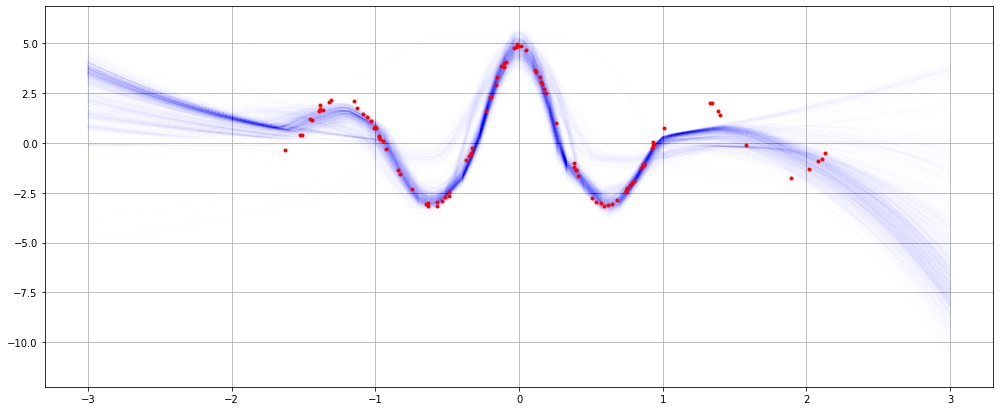

In [346]:
plt.figure(figsize = (17,7))
for i in range(n_post):
    plt.plot(X_pred[:,0],Y_post[i],"b-",alpha = 1./200)
plt.plot(X[:,0],y,"r.")
plt.grid()
plt.show()

Idea is we can look at the uncertainty, if you condition on any particular input then you're gonna be able to characterize both what is the mean and what is the variance of that input, for example if we are predicting at the very left, we are gonna see quite high variance because we are relatively uncertain, but near to 0, we have a lot of agreement between your samples from the approximate posterior so you have higher confidence

In [222]:
class Student:
    def __init__(self):
        self.parameter = 23
        self.nom = "pui" + str(self.parameter)
        self.tem = 0
    def __call__(self):
        print("bonjour")
        self.ff = "Call"
        
    @property
    def tran(self):
        self.parameter = 10 * 2
        

test = Student()

In [229]:
test.tran
test.parameter

20

In [230]:
test.parameter

20

In [231]:
test.nom

'pui23'

In [331]:
a = 'la phrase suivante'

In [333]:
a.split(" ")[0]

'la'

In [343]:
Y_post[i]

array([ 3.2506249 ,  3.07270145,  2.90066481,  2.73432374,  2.57359219,
        2.41838717,  2.26862359,  2.12421656,  1.98332131,  1.84612215,
        1.71433377,  1.58786094,  1.46660888,  1.3504827 ,  1.23887885,
        1.13120282,  1.02778518,  0.92937249,  0.83585948,  0.74714071,
        0.66311055,  0.58366364,  0.541722  ,  0.71568704,  0.8931796 ,
        1.04597223,  1.17504346,  1.2815913 ,  1.36756909,  1.43620098,
        1.46641636,  1.30205822,  1.1050303 ,  0.89394552,  0.64662409,
        0.11203185, -0.58660996, -1.22926307, -1.71817791, -1.92054343,
       -1.96255469, -1.66573322, -1.06853604, -0.39720693,  0.38553926,
        1.27340019,  2.53428555,  3.47667193,  4.21947241,  4.71227121,
        4.53784847,  3.93483424,  3.04496431,  1.82876158,  0.33168417,
       -1.1559025 , -1.58168161, -2.07912517, -2.68266797, -3.2662847 ,
       -3.44039369, -3.26862431, -2.8024466 , -2.22387886, -1.56486034,
       -0.83898687, -0.15697584,  0.22081426,  0.38898638,  0.46

In [350]:
np.full((2,2),None)


array([[None, None],
       [None, None]], dtype=object)

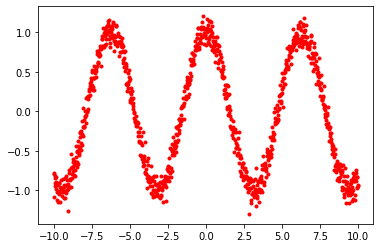

In [347]:
x = np.linspace(-10,10,1000)
y = np.random.normal(np.cos(x),0.1)

plt.plot(x,y,'r.')

In [370]:
X = np.random.randn(2,3)
inter = np.random.randn(2,2)*4
Y = np.diag(np.diag(np.random.randn(2,2)*4))

In [371]:
X.T @ Y @ X

array([[-1.58366493, -1.90890599,  3.24271928],
       [-1.90890599, -2.30153519,  3.92665613],
       [ 3.24271928,  3.92665613, -7.18483563]])

In [372]:
inter

array([[-2.39469405, -4.56757825],
       [ 0.60514641,  1.14610755]])